In [1]:
#import tensorflow as tf
import keras
keras.__version__

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


'2.1.4'

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from keras import backend as K

## Setup run-time configuration

In [5]:
# training data specific names
base_model_name = './models/vgg16_full_base_model.h5'
finetuned_model_name = './models/vgg16_full_finetuned_model.h5'

train_dir = '/mystuff/cats_dogs_data/train_full'

# location for validation and test data
validation_dir = '/mystuff/cats_dogs_data/validation'
test_dir = '/mystuff/cats_dogs_data/test'


# training run specific parameters
BASE_MODEL_EPOCHS=30
FINETUNED_MODEL_EPOCHS=50
BATCH_SIZE = 64

TRAIN_SAMPLES = len(os.listdir(os.path.join(train_dir,'cats'))) + len(os.listdir(os.path.join(train_dir,'dogs')))
VALIDATION_SAMPLES = len(os.listdir(os.path.join(validation_dir,'cats'))) + \
    len(os.listdir(os.path.join(validation_dir,'dogs')))
    
TEST_SAMPLES = len(os.listdir(os.path.join(test_dir,'cats'))) + len(os.listdir(os.path.join(test_dir,'dogs')))

print('Number of samples: training {:d}, validation {:d} and test {:d}'.format(TRAIN_SAMPLES, 
                                                                               VALIDATION_SAMPLES,TEST_SAMPLES))

Number of samples: training 21000, validation 2000 and test 2000


# Using a pre-trained convnet



## Feature extraction for VGG16 model



In [6]:
from keras.applications import VGG16

In [7]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step: 


In [8]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


This is what our model looks like now:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freeze base model layers

In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [12]:
conv_base.trainable = False

In [13]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Setup training data pipeline using data augmenation

In [15]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=BATCH_SIZE,  # original
        #batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Train new classifer specific to cat vs dog using features created by baseline model

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

In [17]:
# set up to capture best performance weights ecountered during training
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./models/weights_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]


history = model.fit_generator(
      train_generator,
      steps_per_epoch=TRAIN_SAMPLES/BATCH_SIZE,
      epochs=BASE_MODEL_EPOCHS,  
      validation_data=validation_generator,
      validation_steps=VALIDATION_SAMPLES/BATCH_SIZE,
      callbacks=callbacks_list,
      verbose=2)

Epoch 1/30
 - 287s - loss: 0.4027 - acc: 0.8198 - val_loss: 0.2257 - val_acc: 0.9055

Epoch 00001: val_acc improved from -inf to 0.90550, saving model to ./models/weights_best.hdf5
Epoch 2/30
 - 164s - loss: 0.3347 - acc: 0.8509 - val_loss: 0.2185 - val_acc: 0.9125

Epoch 00002: val_acc improved from 0.90550 to 0.91250, saving model to ./models/weights_best.hdf5
Epoch 3/30
 - 164s - loss: 0.3208 - acc: 0.8580 - val_loss: 0.2546 - val_acc: 0.8860

Epoch 00003: val_acc did not improve
Epoch 4/30
 - 165s - loss: 0.3077 - acc: 0.8639 - val_loss: 0.2054 - val_acc: 0.9150

Epoch 00004: val_acc improved from 0.91250 to 0.91500, saving model to ./models/weights_best.hdf5
Epoch 5/30
 - 164s - loss: 0.2993 - acc: 0.8667 - val_loss: 0.1984 - val_acc: 0.9155

Epoch 00005: val_acc improved from 0.91500 to 0.91550, saving model to ./models/weights_best.hdf5
Epoch 6/30
 - 165s - loss: 0.2916 - acc: 0.8719 - val_loss: 0.1974 - val_acc: 0.9190

Epoch 00006: val_acc improved from 0.91550 to 0.91900, sav

In [18]:
# load best performance weights
model.load_weights('./models/weights_best.hdf5')

# save trained model
model.save(base_model_name)

Examine learning rates:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


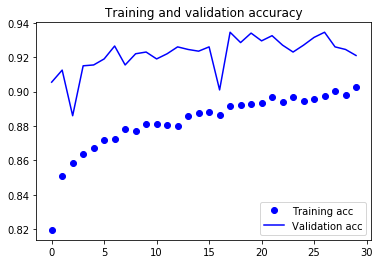

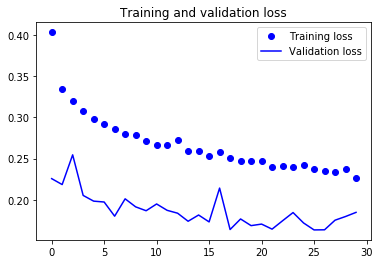

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=TEST_SAMPLES/BATCH_SIZE)
print('base model test acc:', test_acc)

Found 2000 images belonging to 2 classes.
base model test acc: 0.921


## Fine-tuning



Model before setup for fine tuning

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 15,076,865
Non-trainable params: 1,735,488
_________________________________________________________________



Now let's proceed with fine-tuning:

In [26]:
from keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint('./models/weights_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True,
mode='max')

earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='max')

callbacks_list = [checkpoint,earlystop]


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  # use low rate to avoid large changes in cnn layer
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=TRAIN_SAMPLES/BATCH_SIZE,
      epochs=FINETUNED_MODEL_EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_SAMPLES/BATCH_SIZE,
      callbacks=callbacks_list)

Epoch 1/50
329/328 [==============================] - 174s 528ms/step - loss: 0.2151 - acc: 0.9091 - val_loss: 0.1153 - val_acc: 0.9540

Epoch 00001: val_acc improved from -inf to 0.95400, saving model to ./models/weights_best.hdf5
Epoch 2/50
329/328 [==============================] - 170s 517ms/step - loss: 0.1595 - acc: 0.9335 - val_loss: 0.0818 - val_acc: 0.9680

Epoch 00002: val_acc improved from 0.95400 to 0.96800, saving model to ./models/weights_best.hdf5
Epoch 3/50
329/328 [==============================] - 169s 514ms/step - loss: 0.1329 - acc: 0.9460 - val_loss: 0.0765 - val_acc: 0.9690

Epoch 00003: val_acc improved from 0.96800 to 0.96900, saving model to ./models/weights_best.hdf5
Epoch 4/50
329/328 [==============================] - 170s 516ms/step - loss: 0.1219 - acc: 0.9524 - val_loss: 0.0845 - val_acc: 0.9660

Epoch 00004: val_acc did not improve
Epoch 5/50
329/328 [==============================] - 169s 515ms/step - loss: 0.1095 - acc: 0.9563 - val_loss: 0.0611 - val_

329/328 [==============================] - 169s 512ms/step - loss: 0.0254 - acc: 0.9913 - val_loss: 0.0684 - val_acc: 0.9805

Epoch 00044: val_acc did not improve
Epoch 45/50
329/328 [==============================] - 169s 513ms/step - loss: 0.0251 - acc: 0.9915 - val_loss: 0.0686 - val_acc: 0.9835

Epoch 00045: val_acc did not improve
Epoch 46/50
329/328 [==============================] - 170s 516ms/step - loss: 0.0249 - acc: 0.9918 - val_loss: 0.1048 - val_acc: 0.9785

Epoch 00046: val_acc did not improve
Epoch 00046: early stopping


In [27]:
model.load_weights('./models/weights_best.hdf5')
model.save(finetuned_model_name)

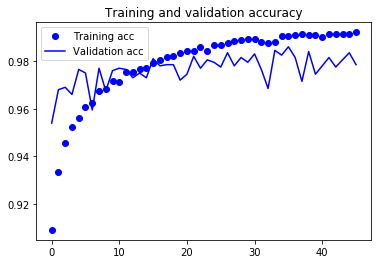

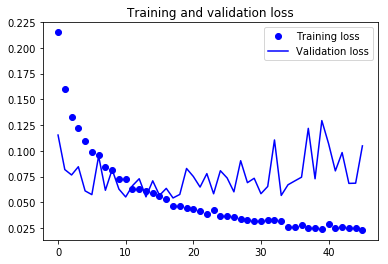

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=TEST_SAMPLES/BATCH_SIZE)
print('fine tuned test acc:', test_acc)

Found 2000 images belonging to 2 classes.
fine tuned test acc: 0.9765
